# Unify immutable Yelp datasets

In [14]:
import os.path as P
import os
import yaml
import math

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt


from IPython.display import display, Markdown, Latex, HTML

import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

project_dir = '/Users/doayakut/Desktop/third'
immutable_dir = P.join(project_dir, 'data', 'immutable')
unified_dir = P.join(project_dir, 'data', 'unified')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
%config InlineBackend.figure_format = 'svg'



In [15]:
def md(s: str):
    display(Markdown(s))

In [16]:
def load_csv(fname: str) -> object:
    logging.debug('Start loading csv file {}'.format(fname))
    df = pd.read_csv(P.join(immutable_dir, fname))
    
    return df


In [17]:
def print_counts(df: pd.DataFrame, fname: str):
    md('**{}**: rows={:,}, columns={:,}, unique_reviewer={:,}'.format(fname, df.shape[0], df.shape[1], df.reviewerID.nunique()))

def print_duplicate_count(df: pd.DataFrame, keys: list, fname: str):
    dups = df[df.duplicated(subset=keys)]
    c1 = dups.shape[0]
    c2 = df.shape[0]
    r = int(c1 / c2 * 100)
    md('**Duplicates in {}**: {}% ({:,}/{:,})'.format(fname, r, c1, c2))

In [18]:
def remove_duplicates(df: pd.DataFrame, keys: list):
    count_cols = [c for c in list(df.columns) if 'Count' in c]
    df['SUM'] = df.apply(lambda x: sum([x[c] for c in count_cols]), axis=1)
    df.sort_values(by=keys + ['SUM'], ascending=False, inplace=True)
    df.drop_duplicates(subset=keys, keep='first', inplace=True)
    df.drop('SUM', axis=1, inplace=True)
    return df

In [19]:
def filter_values(s: pd.Series, l: int, r: int) -> pd.Series:
    s = s.apply(lambda x: x if x <= r and x >= l else l - 1)
    return s[s != l-1]

## 1. Loading Datasets

In [20]:
hotel_og_b = load_csv('yelpHotelData_hotel.csv')
hotel_og_r = load_csv('yelpHotelData_review.csv')
hotel_og_rr = load_csv('yelpHotelData_reviewer.csv')
hotel_new_r = load_csv('yelpHotelNewData_review.csv')
hotel_new_rr = load_csv('yelpHotelNewData_reviewer.csv')

res_og_b = load_csv('yelpResData_restaurant.csv')
res_og_r = load_csv('yelpResData_review.csv')
res_og_rr = load_csv('yelpResData_reviewer.csv')
res_new_r = load_csv('yelpResNewData_review.csv')
res_new_rr = load_csv('yelpResNewData_reviewer.csv')

hotel_og_r.dataset_origin = 'hotel'
res_og_r.dataset_origin = 'res'

hotel_og_r.rename(columns={'hotelID': 'businessID'}, inplace=True)
res_og_r.rename(columns={'restaurantID': 'businessID'}, inplace=True)

md('<code>Datasets loaded.</code>')

print_counts(hotel_og_r, 'Original hotel review dataset')
print_counts(hotel_og_rr, 'Original hotel user dataset')
print_counts(hotel_new_r, 'New hotel review dataset')
print_counts(hotel_new_rr, 'New hotel user dataset')
print_counts(res_og_r, 'Original restaurant review dataset')
print_counts(res_og_rr, 'Original restaurant user dataset')
print_counts(res_new_r, 'New restaurant review dataset')
print_counts(res_new_rr, 'New restaurant user dataset')

<code>Datasets loaded.</code>

**Original hotel review dataset**: rows=688,329, columns=10, unique_reviewer=5,132

**Original hotel user dataset**: rows=5,123, columns=13, unique_reviewer=5,123

**New hotel review dataset**: rows=33,338, columns=11, unique_reviewer=1,792

**New hotel user dataset**: rows=5,120, columns=24, unique_reviewer=5,120

**Original restaurant review dataset**: rows=788,471, columns=10, unique_reviewer=35,430

**Original restaurant user dataset**: rows=16,941, columns=14, unique_reviewer=16,941

**New restaurant review dataset**: rows=460,399, columns=11, unique_reviewer=14,122

**New restaurant user dataset**: rows=35,336, columns=24, unique_reviewer=35,336

## 2. Before statistics, we need to determine which datasets are relevant

**Reverse engineering data collection**

Data collection went something like this: 
- Original datasets (<code>yelpHotelData_\*</code>, <code>yelpResData_\*</code>)
- Collected user information <code>yelpHotelNewData_reviewer</code>, <code>yelpHotelNewData_reviewer</code>
- Collected reviews of these users <code>yelpHotelNewData_review</code>, <code>yelpHotelNewData_review</code>

Bew review datasets are smaller than original datasets (both in review counts and unique reviewer counts) which probably means that I stopped crawling at some point.

So I'm going to use the original review dataset <code>yelp[type]Data_review</code> and the newly gathered user information <code>yelp[type]NewData_reviewer</code>

**One thing before we merge datasets of analysis is whether all the reviews in hotel reviews dataset are for hotels**

Since there is so many reviews belonging to a small number of users (for hotels, N=688329, R=5132) I suspect that the reviews are not just for hotels. Which you can see below.

In [21]:
hotel_og_b.categories.apply(lambda x: 'Hotels' not in x).value_counts().to_dict()

{True: 267881, False: 15205}

## 3. Merge hotel and restaurant datasets

Next we merge hotel and restaurant datasets into one dataset

In [22]:
df_review = pd.concat([hotel_og_r, res_og_r])
df_reviewer = pd.concat([hotel_new_rr, res_new_rr])

df_review = df_review[df_review.reviewerID.isin(df_reviewer.reviewerID.unique())]

print_counts(df_review, 'Review dataset')
print_counts(df_reviewer, 'Reviewer dataset')

**Review dataset**: rows=1,469,311, columns=10, unique_reviewer=38,512

**Reviewer dataset**: rows=40,456, columns=24, unique_reviewer=38,512

## 4. Handling duplicates between hotel and restaurant datasets

There is bound to be differences in the two datasets, Since data collection is inherently not simultaneous, as users edit their profiles and reviews.

Since timestamp of data collection does not exist, we approximate by using number of counts (assuming that friendcount, funnyvotecount would increase over time)

In [23]:
print_duplicate_count(df_review, ['reviewID', 'reviewerID'], 'Review Dataset')
print_duplicate_count(df_reviewer, ['reviewerID'], 'Reviewer Dataset')

df_review = remove_duplicates(df_review, ['reviewID', 'reviewerID'])
df_reviewer = remove_duplicates(df_reviewer, ['reviewerID'])
md('<code>Duplicates removed.</code>')

print_duplicate_count(df_review, ['reviewID', 'reviewerID'], 'Review Dataset')
print_duplicate_count(df_reviewer, ['reviewerID'], 'Reviewer Dataset')

print_counts(df_review, 'Review dataset')
print_counts(df_reviewer, 'Reviewer dataset')

**Duplicates in Review Dataset**: 12% (180,979/1,469,311)

**Duplicates in Reviewer Dataset**: 4% (1,944/40,456)

<code>Duplicates removed.</code>

**Duplicates in Review Dataset**: 0% (0/1,288,332)

**Duplicates in Reviewer Dataset**: 0% (0/38,512)

**Review dataset**: rows=1,288,332, columns=10, unique_reviewer=38,512

**Reviewer dataset**: rows=38,512, columns=24, unique_reviewer=38,512

## 5. Handling flag types [Y - YR - N - NR]

**!! Previous papers only used Y/N flags**

"Reviews with YR/NR: Reviews obtained from the reviewer profile page. These reviews are not just for restaurants but for every business the reviewer put a review for. We used it to identify how many of his reviews were filtered. The YR is determined by whether the review was availble on that particular business page. If it wasnt present (we determine this by crawling every page for that business exhaustively) we gave it YR as in we assumed it was filtered. If it was present it was given a NR value."

\- *Mukherjee, Arjun, et al. "What yelp fake review filter might be doing?." Seventh international AAAI conference on weblogs and social media. 2013.*

Below, I make sure that the number of reviewers who have at least one review with Y/N flag is not too low. Which it turns out isn't low, so we can just limit the reviewers to ones have at least one reviews with Y/N flags.

In [24]:
d = df_review.flagged.value_counts().to_dict()
reviewers_YN = df_review[df_review.flagged.isin(['N', 'Y'])].reviewerID

md('**Number of reviews per flag type:** ' + ', '.join([k + ': ' + str(v) for k, v in d.items()]))    
md('**Number of reviewers with reviews flaggeds as Y or N:** {} out of {} reviewers'.format(reviewers_YN.nunique(), df_review.reviewerID.nunique()))

df_review = df_review[df_review.reviewerID.isin(reviewers_YN)]
df_reviewer = df_reviewer[df_reviewer.reviewerID.isin(reviewers_YN)]

print_counts(df_review, 'Review Dataset')
print_counts(df_reviewer, 'Reviewer Dataset')

**Number of reviews per flag type:** NR: 706546, YR: 514522, N: 58343, Y: 8921

**Number of reviewers with reviews flaggeds as Y or N:** 38015 out of 38512 reviewers

**Review Dataset**: rows=1,270,557, columns=10, unique_reviewer=38,015

**Reviewer Dataset**: rows=38,015, columns=24, unique_reviewer=38,015

## 6. Add flag counts to reviewer dataset 

The flag label is associated with reviews and not the reviewers. I also want to calculate a reviewers flag counts since I might use it later on.



In [25]:
flag_cols = {'flagCount' + f: f for f in ['Y', 'N', 'YR', 'NR']}
for c, f in flag_cols.items():
    df_review[c] = df_review.flagged == f
    
df_flag_counts = df_review.groupby('reviewerID')[list(flag_cols.keys())].sum().astype(int)
df_flag_counts.reset_index(inplace=True)

df_reviewer = df_reviewer.merge(df_flag_counts, on='reviewerID')
df_review.drop(list(flag_cols.keys()), axis=1, inplace=True)

## 7. Add review count in dataset

When I looked at the reviewer.reviewCount, they do not match the numbers in the dataset. Assuming the reviewer details and review's are collected at the same time, this difference is unexpected. 

Todo: Look at this difference. This might be 

For now, I'll add another field to the reviewer dataset indicating the review count in dataset.

In [26]:
x = df_review.reviewerID.value_counts()
x = pd.DataFrame({'reviewerID': x.index.values, 'reviewDatasetCount': x.values})

df_reviewer = df_reviewer.merge(x, on='reviewerID')
df_reviewer.head(3)

reviewerID                                      name  \
0  zzzW81llRc2vMWX0VrTJzw                                   Kaye A.   
1  zzmVpziv5OsjmtshptyA9Q  GeminiDreamweapon "GeminiDreamweapon" M.   
2  zzK05ZbEva9FGAjEFWlGFg                                 Trisha F.   

          location   yelpJoinDate  friendCount  reviewCount  firstCount  \
0  Minneapolis, MN   October 2011            0            1           0   
1  Archer City, TX    August 2009            9           18           1   
2  San Leandro, CA  December 2006          129          161          19   

   usefulCount  coolCount  funnyCount  complimentCount  tipCount  fanCount  \
0            0          0           0                0         0         0   
1           82         26          17                4         2         2   
2          228         73          47               15         4         0   

  eliteYears  rating5Count  rating4Count  rating3Count  rating2Count  \
0        NaN             0             0             0             0   
1        NaN            14             1             1             0   
2        NaN            19            76            44            12   

   rating1Count  updateCount  localPhotoCount  listCount hasBlog  \
0             0            0                0          0       N   
1             2            3               12          0       Y   
2            10            0               22          4       Y   

  hasProfilePicture  flagCountY  flagCountN  flagCountYR  flagCountNR  \
0                 N           1           0            0            0   
1                 N           0           1            0            0   
2                 N           0           1           61           83   

   reviewDatasetCount  
0                   1  
1                   1  
2                 145

## 8. Save files

In [27]:
if not os.listdir(unified_dir):
    df_reviewer.to_csv(P.join(unified_dir, 'yelpReviewer.csv'), index=False)
    df_review.to_csv(P.join(unified_dir, 'yelpReview.csv'), index=False)
    md('Saved.')
else: 
    md('!!! Folder not empty')
    

Saved.

## 9. Vocabulary

Here we need to take into account several things.

- Uppercase vs lowercase
- Special characters (i.e commas)



# Review dataset overview

In [51]:
df_review.head(5)

date                reviewID              reviewerID  \
476816   3/6/2012  zzzyFmzWc5Spl2-dGQf8aQ  NaCQV0ipydRvCvzjne4IzQ   
190632   4/2/2011  zzzQ3s2sAqTZeH2aqQpWgA  ziBhmecaEZY49TMJb6yB_A   
395049  4/23/2009  zzyllvAr3xA8CJtfmh8LCQ  2YuYRqSTsqHHZaiWXpo3Aw   
532916  6/23/2008  zzybAPT23-iB__8_ARFYNQ  N9xkt5ow474Q10dEwNoHQg   
163523   2/6/2012  zzyVTwYK9DyqEq4sYWZeJQ  HAu5OgbkLGsmLhKBJ2RR1g   

                                            reviewContent  rating  \
476816  Being a Chicagoan i'm super picky about steakh...       5   
190632  If you are looking for a greasy and delicious ...       4   
395049  Likes: - It was really close to my old apartme...       2   
532916  If you value your clothing, go elsewhere.  I h...       1   
163523  I've only been here once.  I had the green tea...       4   

        usefulCount  coolCount  funnyCount flagged              businessID  
476816            1          0           0      NR  DHCg4SNAp6WzGQ4Lt0avBQ  
190632            0          0           0      NR  vqCfdZCRH7h6eAB0U7ANGg  
395049            5          3           3      YR  dXh-XIrX-MpoUWyid8VlQQ  
532916            1          0           0      NR  z9P4845oUPw0TGXWoomqoQ  
163523            0          0           0      YR  0WyRlH-fxOVLh1b3oEBEEQ

### Flag distribution

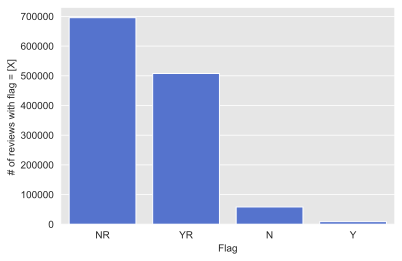

In [52]:
md('### Flag distribution')
ax = sns.countplot(df_review.flagged, color='royalblue')
ax.set(xlabel='Flag', ylabel='# of reviews with flag = [X] ')
plt.show()


### Rating distribution

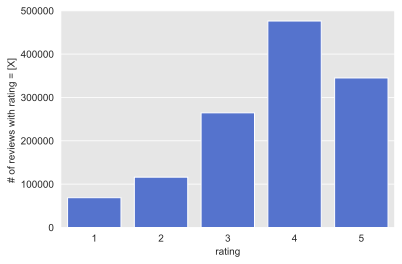

In [53]:
md('### Rating distribution')
ax = sns.countplot(df_review.rating, color='royalblue')
ax.set(xlabel='rating', ylabel='# of reviews with rating = [X] ')
plt.show()


## Votes

### Useful vote distribution

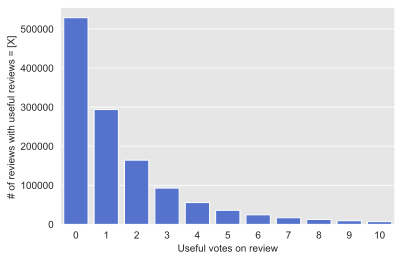

### Funny vote distribution

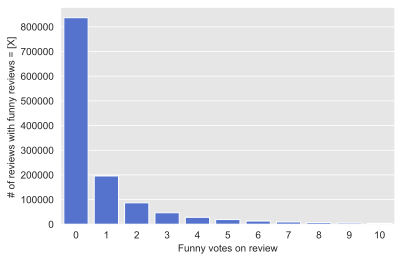

### Cool vote distribution

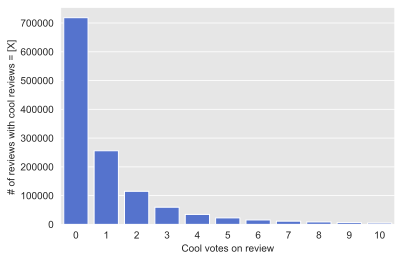

In [54]:

md('## Votes')
md('### Useful vote distribution')
x = filter_values(df_review.usefulCount, 0, 10)
ax = sns.countplot(x, color='royalblue')
ax.set(xlabel='Useful votes on review', ylabel='# of reviews with useful reviews = [X] ')
plt.show()

md('### Funny vote distribution')
x = filter_values(df_review.funnyCount, 0, 10)
ax = sns.countplot(x, color='royalblue')
ax.set(xlabel='Funny votes on review', ylabel='# of reviews with funny reviews = [X] ')
plt.show()

md('### Cool vote distribution')
x = filter_values(df_review.coolCount, 0, 10)
ax = sns.countplot(x, color='royalblue')
ax.set(xlabel='Cool votes on review', ylabel='# of reviews with cool reviews = [X] ')
plt.show()


### Content length (by character) distribution

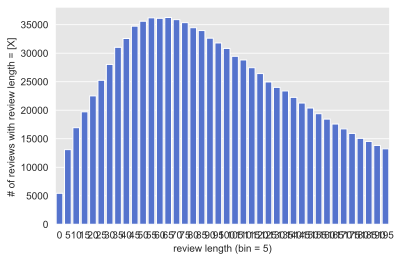

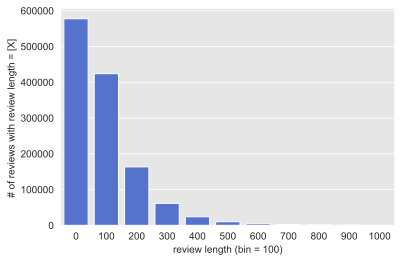

In [58]:
md('### Content length (words) distribution')

def wcount(x): return len(x.split())

x = df_review.reviewContent.astype(str).apply(wcount)
ax = sns.boxplot(x, color='royalblue')
ax.set(xlabel='review length')
plt.show()

bin_size = 5
x = df_review.reviewContent.astype(str).apply(wcount).apply(lambda x: int(x/bin_size) * bin_size)
ax = sns.countplot(x[x<200], color='royalblue')
ax.set(xlabel='review length (bin = {})'.format(bin_size), ylabel='# of reviews with review length = [X] ')
plt.show()

bin_size = 100
x = df_review.reviewContent.astype(str).apply(wcount).apply(lambda x: int(x/bin_size) * bin_size)
ax = sns.countplot(x, color='royalblue')
ax.set(xlabel='review length (bin = {})'.format(bin_size), ylabel='# of reviews with review length = [X] ')
plt.show()

In [ ]:
md('### Vocabulary distribution')

# Reviewer dataset overview


In [118]:
df_reviewer.head(5)

reviewerID                                      name  \
0  zzzW81llRc2vMWX0VrTJzw                                   Kaye A.   
1  zzmVpziv5OsjmtshptyA9Q  GeminiDreamweapon "GeminiDreamweapon" M.   
2  zzK05ZbEva9FGAjEFWlGFg                                 Trisha F.   
3  zzGRHRDrx8H7LXFd5QFJ_w                    Rafael "superduper" G.   
4  zz71QiP13ESB37uuzspRMA                                  Allen P.   

           location    yelpJoinDate  friendCount  reviewCount  firstCount  \
0   Minneapolis, MN    October 2011            0            1           0   
1   Archer City, TX     August 2009            9           18           1   
2   San Leandro, CA   December 2006          129          161          19   
3        Austin, TX  September 2008            5           15           0   
4  San Clemente, CA   December 2008            6           15           0   

   usefulCount  coolCount  funnyCount  complimentCount  tipCount  fanCount  \
0            0          0           0                0         0         0   
1           82         26          17                4         2         2   
2          228         73          47               15         4         0   
3           24          4           3                0         0         2   
4            9          2           1                0         0         0   

  eliteYears  rating5Count  rating4Count  rating3Count  rating2Count  \
0        NaN             0             0             0             0   
1        NaN            14             1             1             0   
2        NaN            19            76            44            12   
3        NaN             6             8             1             0   
4        NaN             6             3             3             1   

   rating1Count  updateCount  localPhotoCount  listCount hasBlog  \
0             0            0                0          0       N   
1             2            3               12          0       Y   
2            10            0               22          4       Y   
3             0            0                0          3       Y   
4             2            0               16          0       N   

  hasProfilePicture  flagCountY  flagCountN  flagCountYR  flagCountNR  
0                 N           1           0            0            0  
1                 N           0           1            0            0  
2                 N           0           1           61           83  
3                 N           0           2            0            0  
4                 N           0           2            0            0

### Review counts

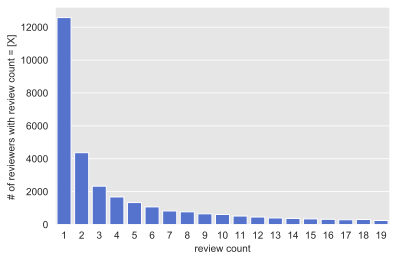

In [162]:
md('### Review counts')
x = df_review.reviewerID.value_counts()
ax = sns.countplot(x[x<20], color='royalblue')
ax.set(xlabel='Review count', ylabel='# of reviewers with review count = [X] ')
plt.show()